In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score, classification_report

experiment_log = []

def run_experiment(name, model, X, y):
    print(f"\n--- Running: {name} ---")
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_auprc = []
    fold_recall = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
        
        probs = model.predict_proba(X_val)[:, 1]
        preds = model.predict(X_val)
        
        auprc = average_precision_score(y_val, probs)
        report = classification_report(y_val, preds, output_dict=True, zero_division=0)
        recall = report['1']['recall']
        
        fold_auprc.append(auprc)
        fold_recall.append(recall)
    
    # Calculate Average
    avg_auprc = np.mean(fold_auprc)
    avg_recall = np.mean(fold_recall)
    
    print(f"Results: AUPRC={avg_auprc:.4f} | Recall={avg_recall:.4f}")
    
    experiment_log.append({
        'Experiment': name,
        'AUPRC': avg_auprc,
        'Recall (Fraud)': avg_recall,
        'Model Config': str(model.get_params())
    })

In [6]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
from src.data_loader import load_data
df = load_data()
print(f"Data Loaded: {df.shape}")


2026-01-08 23:41:21,527 - INFO - Loading data from data/creditcard.parquet...


Data Loaded: (284807, 31)


In [44]:
results_df = pd.DataFrame()
X_raw = df.drop(['class'], axis=1)
y_raw = df['class']
# EXPERIMENT 1: NAIVE BASELINE
# No weights, default settings
model_naive = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    n_jobs=-1,
    eval_metric='aucpr'
)
run_experiment("1. Naive Baseline", model_naive, X_raw, y_raw)
results_df = pd.DataFrame(experiment_log)


--- Running: 1. Naive Baseline ---
Results: AUPRC=0.8380 | Recall=0.7886


In [45]:
# --- EXPERIMENT 2: WEIGHTED BASELINE ---
# Same data, but fix the class imbalance
ratio = float(np.sum(y_raw == 0)) / np.sum(y_raw == 1)
model_weighted = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=ratio, 
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    n_jobs=-1,
    eval_metric='aucpr'
)
run_experiment("2. Weighted Baseline", model_weighted, X_raw, y_raw)
results_df = pd.DataFrame(experiment_log)


--- Running: 2. Weighted Baseline ---
Results: AUPRC=0.8119 | Recall=0.8557


In [14]:
from sklearn.ensemble import IsolationForest

def feature_engineer(df):
    df_eng = df.copy()
    df_eng['hour_of_day'] = df_eng['time'].apply(lambda x: np.floor(x / 3600) % 24)
    df_eng['hour_sin'] = np.sin(2* np.pi * df_eng['hour_of_day'] / 24.0)
    df_eng['hour_cos'] = np.cos(2* np.pi * df_eng['hour_of_day'] / 24.0)

    df_eng = df_eng.sort_values('time')
    temp_indexer = pd.to_datetime(df_eng['time'], unit = 's')
    df_eng['velocity_60s'] = df_eng.set_index(temp_indexer).rolling('60s')['amount'].count().values

    df_eng['V14_V10_interact'] = df_eng['v14'] * df_eng['v10']

    iso = IsolationForest(n_estimators=100, contamination=0.01, random_state=42, n_jobs=-1)
    top_features = ['v14', 'v10', 'v12', 'v4', 'v11']
    df_eng['anomaly_score'] = iso.fit_predict(df_eng[top_features])
    
    return df_eng

In [46]:
# --- EXPERIMENT 3: FEATURE ENGINEERING ---

df_eng = feature_engineer(df)

# 2. Prepare X and y
# We drop the raw 'time' and 'amount' because we have 'velocity_60s', 'hour_sin', etc.
X_eng = df_eng.drop(['class', 'time', 'amount','hour_of_day'], axis=1)
y_eng = df_eng['class']

model_eng = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=ratio,  # Keep the weights!
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    n_jobs=-1,
    eval_metric='aucpr'
)

run_experiment("3. Feature Engineered", model_eng, X_eng, y_eng)
results_df = pd.DataFrame(experiment_log)



--- Running: 3. Feature Engineered ---
Results: AUPRC=0.7980 | Recall=0.8577


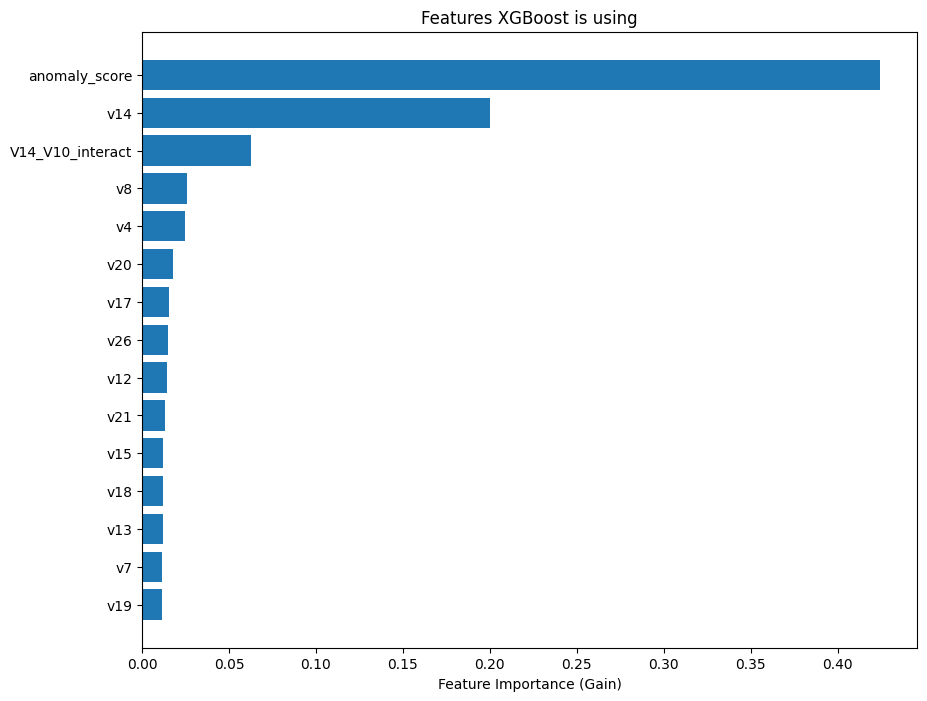

In [37]:
import matplotlib.pyplot as plt

model_eng.fit(X_eng, y_eng, verbose=False)

importance = model_eng.feature_importances_
feature_names = X_eng.columns

fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
fi_df = fi_df.sort_values(by='Importance', ascending=False).head(15) # Top 15

plt.figure(figsize=(10, 8))
plt.barh(fi_df['Feature'], fi_df['Importance'], color='#1f77b4')
plt.xlabel('Feature Importance (Gain)')
plt.title('Features XGBoost is using')
plt.gca().invert_yaxis() # Highest at top
plt.show()

In [47]:
# --- EXPERIMENT 4: PRUNED FEATURES  ---


drop_cols = [
    'class', 'time', 'amount', 'hour_of_day', 
    'anomaly_score',                          
    'velocity_60s',                           
    'hour_sin', 'hour_cos'                   
]

X_pruned = df_eng.drop(drop_cols, axis=1)
y_pruned = df_eng['class']


model_pruned = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=ratio,
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    n_jobs=-1,
    eval_metric='aucpr'
)

run_experiment("4. Pruned (Interaction Only)", model_pruned, X_pruned, y_pruned)
results_df = pd.DataFrame(experiment_log)
print(results_df[['Experiment', 'AUPRC', 'Recall (Fraud)']])


--- Running: 4. Pruned (Interaction Only) ---
Results: AUPRC=0.8030 | Recall=0.8597
                     Experiment     AUPRC  Recall (Fraud)
0             1. Naive Baseline  0.837980        0.788600
1          2. Weighted Baseline  0.811853        0.855679
2         3. Feature Engineered  0.798013        0.857699
3  4. Pruned (Interaction Only)  0.802982        0.859720


In [49]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 4, 6],                 
    'learning_rate': [0.05, 0.1],           
    'n_estimators': [100, 200, 300],        
    'scale_pos_weight': [ratio, ratio*1.5], 
    'subsample': [0.8],                     
    'colsample_bytree': [0.8]               
}

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_jobs=-1,
    eval_metric='aucpr'
)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='average_precision',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Total fits = (3 depths * 2 LRs * 3 n_est * 2 weights) * 3 CV folds = 108 fits
grid_search.fit(X_pruned, y_pruned)

print(f"\nBEST AUPRC SCORE: {grid_search.best_score_:.4f}")
print("BEST PARAMETERS:", grid_search.best_params_)

# Save the best model object for later use
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 36 candidates, totalling 108 fits

BEST AUPRC SCORE: 0.7983
BEST PARAMETERS: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'scale_pos_weight': np.float64(866.814024390244), 'subsample': 0.8}


In [50]:
final_params = grid_search.best_params_

model_tuned = xgb.XGBClassifier(
    objective='binary:logistic',
    n_jobs=-1,
    eval_metric='aucpr',
    **final_params
)

run_experiment("5. Tuned XGBoost", model_tuned, X_pruned, y_pruned)

results_df = pd.DataFrame(experiment_log)
print(results_df.sort_values(by='AUPRC', ascending=False)[['Experiment', 'AUPRC', 'Recall (Fraud)']])


--- Running: 5. Tuned XGBoost ---
Results: AUPRC=0.8417 | Recall=0.8495
                     Experiment     AUPRC  Recall (Fraud)
4              5. Tuned XGBoost  0.841683        0.849516
0             1. Naive Baseline  0.837980        0.788600
1          2. Weighted Baseline  0.811853        0.855679
3  4. Pruned (Interaction Only)  0.802982        0.859720
2         3. Feature Engineered  0.798013        0.857699
